### Note:
This notebook is used for the data preprocessing. The author primarly preprocessed the data for Yolov7. I have later added some adjustmnet to use it with Yolo_NAS.

In [2]:
from PIL import Image, ImageDraw, ImageFont
import shutil

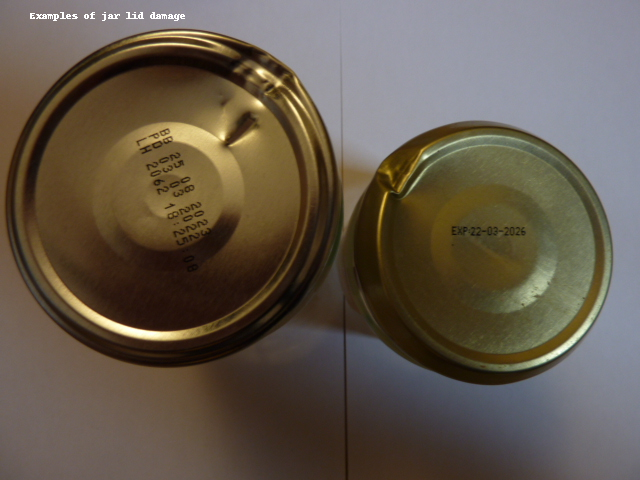

In [3]:
img = Image.open("raw_data/p20.jpg")
i1 = ImageDraw.Draw(img)
#font = ImageFont.truetype()
i1.text((30, 10), "Examples of jar lid damage", fill=(255, 255, 255))
img

In [4]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import json
import sys
import os
import shutil
from distutils.dir_util import copy_tree
import imagesize
import ptitprince as pt
from shutil import copyfile
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches
import seaborn as sns
import re

In [7]:
annots = 'jarlids_annots.csv'   # the annotation csv file from the donwloaded dataset
imagefiles = 'raw_data/'  # folder containing all your images
dest = 'dest/'  # folder to where you would like to move your data
results = 'raw_data/results.txt'  

In [5]:
yfile='train.yaml'
tr_start=1
tr_end=125
va_start=200
va_end=239
te_start=1
te_end=6
va_te='val.txt'

In [6]:
class prepare_annotations():
    def __init__(self, sourcedir=annots, imagesdir=imagefiles, destdir=dest, namedir=dest, yamlfile=yfile, filename='im1.jpg', trainstart=tr_start, trainend=tr_end, valstart=va_start, valend=va_end, teststart=te_start, testend=te_end, validationtest=va_te):
        self.sourcedir = sourcedir # directory where annotation data in CSV format are.
        self.imagesdir = imagesdir # directory where original images are.
        self.destdir = destdir # directory where annotations should be put.
        self.namedir = namedir # directory where files are read when Yolov is run; paths are in the .txt and .yaml
        self.yamlfile = yamlfile # name given to the yamlfile 
        self.filename = filename # for ex. p1.jpg
        self.trainstart = trainstart # where train data start
        self.trainend = trainend # where train data end (not including)
        self.valstart = valstart # where validation data start
        self.valend = valend # where validation data end (not including)
        self.teststart = teststart # where testdata start
        self.testend = testend # where testdata end
        self.validationtest = validationtest # name of file used in test, can be 'val.txt' or 'test.txt'
        
    def isize(self, imagesdir, filename):
        """
        Measures image dimensions without loading the image, using the package imagesize.
        imagesdir: path directory to the image files
        filename: name of image file
        """
        w, h = imagesize.get(os.path.join(imagesdir, filename))
        return(w, h)
        
    def load_dataframe(self):
        """
        Loads annotation data with bounding box information and performs preprocessing
        """
        dat = pd.read_csv(self.sourcedir)
        tr = ['p'+str(s)+'.JPG' for s in range(self.trainstart, self.trainend)]
        va = ['p'+str(s)+'.JPG' for s in range(self.valstart, self.valend)]
        te = ['t'+str(s)+'.JPG' for s in range(self.teststart, self.testend)]
        for i,j in zip(['train', 'val', 'test'], [tr, va, te] ):
            dat.loc[dat['filename'].isin(j), 'dataset'] = i
        dat['region_attributes']= dat['region_attributes'].replace({'{}': 'None'})
        dat = dat[~dat['region_attributes'].isin(['None'])].reset_index(drop=False)
        dat['category_names'] = dat['region_attributes'].apply(lambda x: str(list(eval(x).values())[0]))
        dat['category_codes'] = dat[['category_names']].apply(lambda x: pd.Categorical(x).codes)
        dat['image_width'] = dat['filename'].apply(lambda x: self.isize(self.imagesdir, x)[0])
        dat['image_height'] = dat['filename'].apply(lambda x: self.isize(self.imagesdir, x)[1])
        dat['x_min'] = dat['region_shape_attributes'].apply(lambda x: eval(x)['x'])
        dat['y_min'] = dat['region_shape_attributes'].apply(lambda x: eval(x)['y'])
        dat['bb_width'] = dat['region_shape_attributes'].apply(lambda x: eval(x)['width'])
        dat['bb_height'] = dat['region_shape_attributes'].apply(lambda x: eval(x)['height'])
        dat['n_x_center'] = (((dat['x_min'] + dat['bb_width']) + dat['x_min']) / 2) / dat['image_width'] 
        dat['n_y_center'] = (((dat['y_min'] + dat['bb_height']) + dat['y_min']) / 2) / dat['image_height'] 
        dat['n_width'] = dat['bb_width'] / dat['image_width'] 
        dat['n_height'] = dat['bb_height'] / dat['image_height']
        dat['color_cat'] = dat['category_names'].replace({'intact': 'green', 'damaged': 'red'})
        dat = dat.reset_index(drop=True)   
        return(dat)
    
    def make_dirstructure(self):
        """
        Creates directory structure and copies image files
        """
        try:
            print('new directory tree prepared')
            os.makedirs(self.destdir, exist_ok=True)
            os.makedirs(os.path.join(self.destdir, 'images/'), exist_ok=True)
            os.makedirs(os.path.join(self.destdir, 'labels/'), exist_ok=True)
        except:
            print('no new directory was made, probably already existing')
                
        dat = self.load_dataframe()
        filenames = list(set(dat['filename']))
        for f in filenames:
            copyfile(os.path.join(self.imagesdir, f), os.path.join(self.destdir, 'images', f))
                                                
    def make_labels(self):
        """
        Saves bounding box data for given filenames as txt file for each image.
        """
        dat = self.load_dataframe()
        print('length data:', len(dat))
        print('Emptying labelfiles')
        for i in list(set(dat['filename'])):
            try:
                os.remove(os.path.join(self.destdir, 'labels/', i[:-4]+'.txt'))
            except:
                pass

        print('Collecting bounding boxes, saving them to:', os.path.join(self.destdir, 'labels/'))
        for i in range(0,len(dat)):
            try:
                with open(os.path.join(self.destdir, 'labels/', dat['filename'][i][:-4]+'.txt'), "a") as f:
                    print(dat['category_codes'][i], dat['n_x_center'][i], dat['n_y_center'][i], dat['n_width'][i], dat['n_height'][i], file=f)
            except:
                print('something went wrong at', i)

    def fixed_train_val_split(self):
        """
        Images are separated given index. Images that contained the same jarlids but photographed from a different angle were in the same split
        """
        dat = self.load_dataframe()
    
        tr = ['p'+str(i)+'.JPG' for i in range(self.trainstart,self.trainend)]
        va = ['p'+str(i)+'.JPG' for i in range(self.valstart, self.valend)]
        te = ['t'+str(i)+'.JPG' for i in range(self.teststart, self.testend)]
        print('Splitting train and validation data')
        
        try:
            print("Removed previous files")
            os.remove('train.txt')
            os.remove('val.txt')
            os.remove('test.txt')
        except:
            print("No previous files train.txt, val.txt or test.txt were found")
        
        with open(os.path.join(self.destdir, 'train.txt'), "a") as f:
            for i in range(len(tr)):
                print(os.path.join(self.namedir, 'images', tr[i]), file=f)   
        with open(os.path.join(self.destdir, 'val.txt'), "a") as f:
            for i in range(len(va)):
                print(os.path.join(self.namedir, 'images', va[i]), file=f)   
        with open(os.path.join(self.destdir, 'test.txt'), "a") as f:
            for i in range(len(te)):
                print(os.path.join(self.namedir, 'images', te[i]), file=f)   
                
    def yaml_file(self):
        """
        *lb: labels such as 'cat', 'dog'
        namedir: # name directory where Docker Yolov5 reads the files.
        yamlfile: name of the design file 
        validationtest: requires val.txt or test.txt
        """
        dat = self.load_dataframe()
        lb = list(sorted(set(dat['category_names'])))
  
        with open(os.path.join(self.destdir, self.yamlfile), "a") as f:
            print('yaml:', file=f)
            print('names:', file=f)
            for i in lb:
                print('- ', i, file=f)
            print('nc:', len(lb), file=f)
            print('train: ', os.path.join(self.namedir, 'train.txt'), file=f)
            print('val: ', os.path.join(self.namedir, self.validationtest), file=f)

In [7]:
df = prepare_annotations().load_dataframe()
df.head()

,index,Unnamed: 0,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,dataset,...,image_height,x_min,y_min,bb_width,bb_height,n_x_center,n_y_center,n_width,n_height,color_cat
0,0,0,p1.JPG,167996,{},12,0,"{""name"":""rect"",""x"":70,""y"":46,""width"":120,""heig...","{""type"":""intact""}",train,...,480,70,46,120,112,0.203125,0.212500,0.187500,0.233333,green
1,1,1,p1.JPG,167996,{},12,1,"{""name"":""rect"",""x"":195,""y"":60,""width"":118,""hei...","{""type"":""intact""}",train,...,480,195,60,118,99,0.396875,0.228125,0.184375,0.206250,green
2,2,2,p1.JPG,167996,{},12,2,"{""name"":""rect"",""x"":318,""y"":25,""width"":144,""hei...","{""type"":""damaged""}",train,...,480,318,25,144,120,0.609375,0.177083,0.225000,0.250000,red
3,3,3,p1.JPG,167996,{},12,3,"{""name"":""rect"",""x"":474,""y"":13,""width"":135,""hei...","{""type"":""intact""}",train,...,480,474,13,135,122,0.846094,0.154167,0.210938,0.254167,green
4,4,4,p1.JPG,167996,{},12,4,"{""name"":""rect"",""x"":45,""y"":162,""width"":123,""hei...","{""type"":""intact""}",train,...,480,45,162,123,116,0.166406,0.458333,0.192188,0.241667,green


In [8]:
def visualisation_annotations(dat, filedir, fname):
    """
    dat: input pandas DataFrame
    filedir: directory where image files can be found
    fname: filename to be visualized, for ex 'p1.JPG'  
    """
    im = Image.open(os.path.join(filedir, fname))
    fig, ax = plt.subplots(figsize=(14, 20))
    ax.imshow(im)
    ndat = dat[dat['filename'] == fname].reset_index()
        
    for i in range(len(ndat)):    
        xmin = ndat['x_min'][i]
        ymin = ndat['y_min'][i]
        w = ndat['bb_width'][i]
        h = ndat['bb_height'][i]
        color = ndat['color_cat'][i]
        rect = patches.Rectangle((xmin, ymin), w, h, linewidth=2, edgecolor=color, facecolor='none') # takes x, y, width and height.
        ax.add_patch(rect)
        
    mpatches_dat = pd.DataFrame(df[['category_names', 'color_cat']].value_counts().reset_index())
    patch1 = mpatches.Patch(color=mpatches_dat['color_cat'][0], label=mpatches_dat['category_names'][0])
    patch2 = mpatches.Patch(color=mpatches_dat['color_cat'][1], label=mpatches_dat['category_names'][1])
    ax.legend(handles=[patch1, patch2])
        
    plt.show()

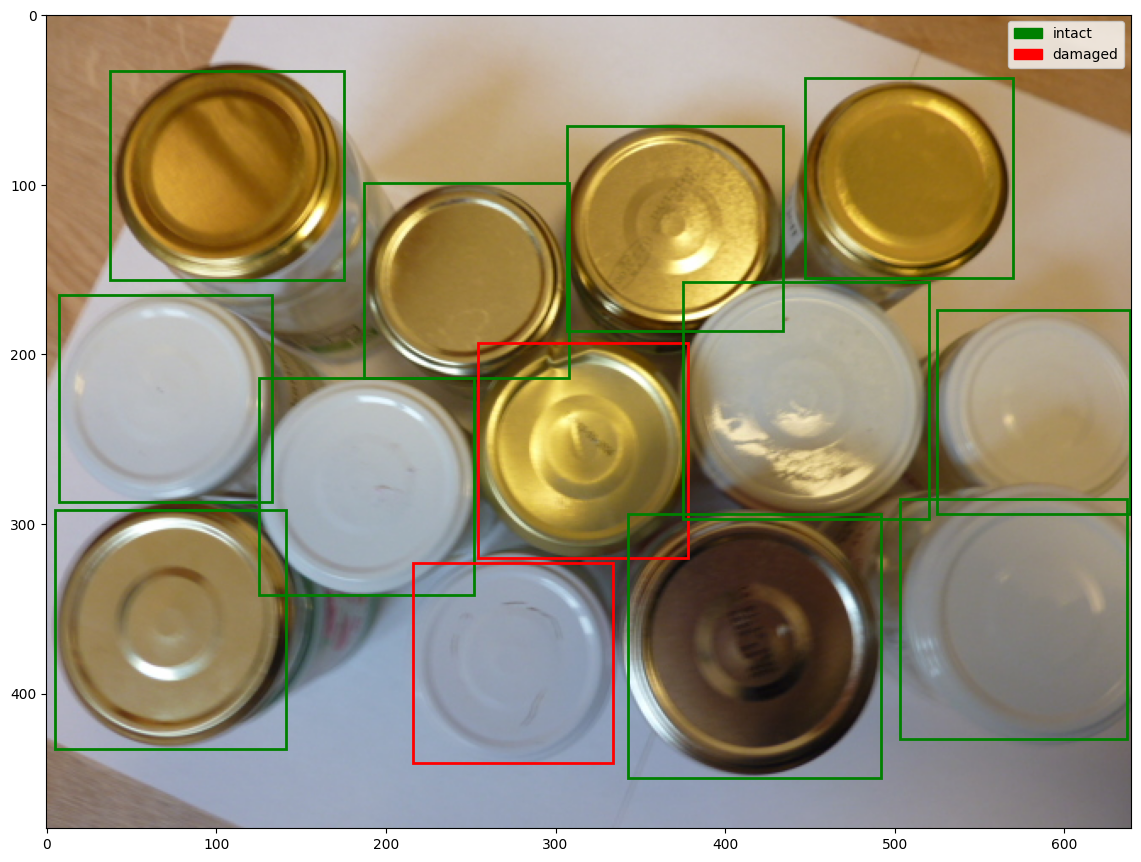

In [9]:
visualisation_annotations(df, imagefiles, 'p15.JPG')

Text(0.5, 1.0, 'Bounding box width between intact and damaged jarlids')

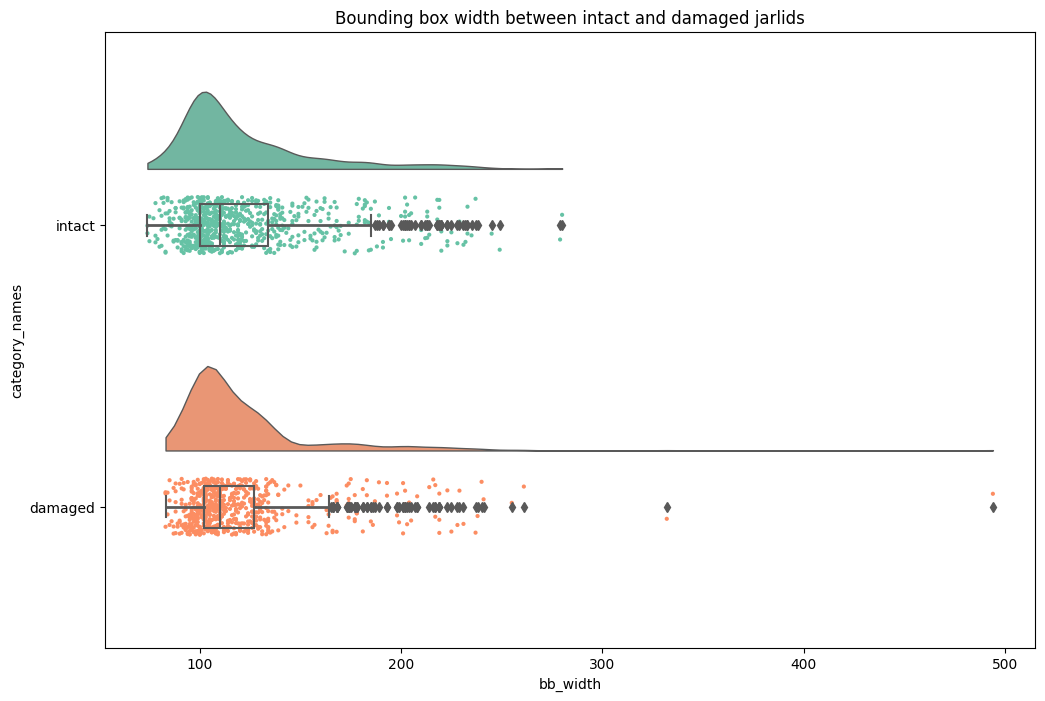

In [10]:
f, ax = plt.subplots(figsize=(12, 8))

pt.RainCloud(x = "category_names", y = "bb_width", data = df[df['dataset'] == 'train'], palette = "Set2", bw = .2,
                 width_viol = .6, ax = ax, orient = "h")

plt.title("Bounding box width between intact and damaged jarlids")

Text(0.5, 1.0, 'Bounding box height between intact and damaged jarlids')

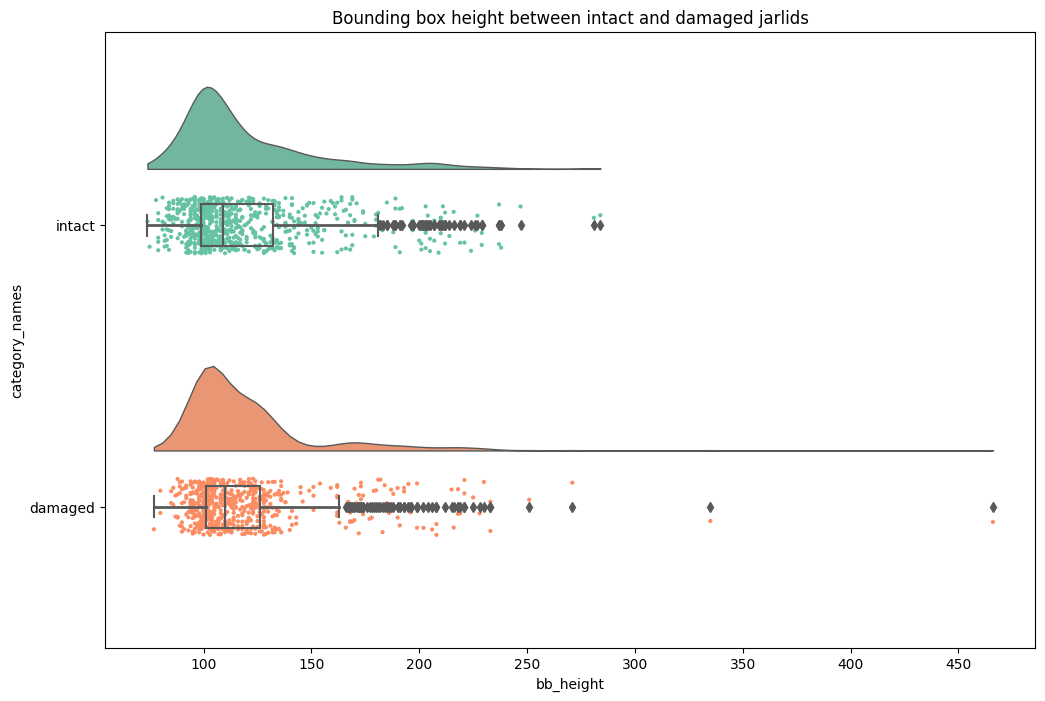

In [11]:
f, ax = plt.subplots(figsize=(12, 8))

pt.RainCloud(x = "category_names", y = "bb_height", data = df[df['dataset'] == 'train'], palette = "Set2", bw = .2,
                 width_viol = .6, ax = ax, orient = "h")

plt.title("Bounding box height between intact and damaged jarlids")

<AxesSubplot:xlabel='bb_width', ylabel='bb_height'>

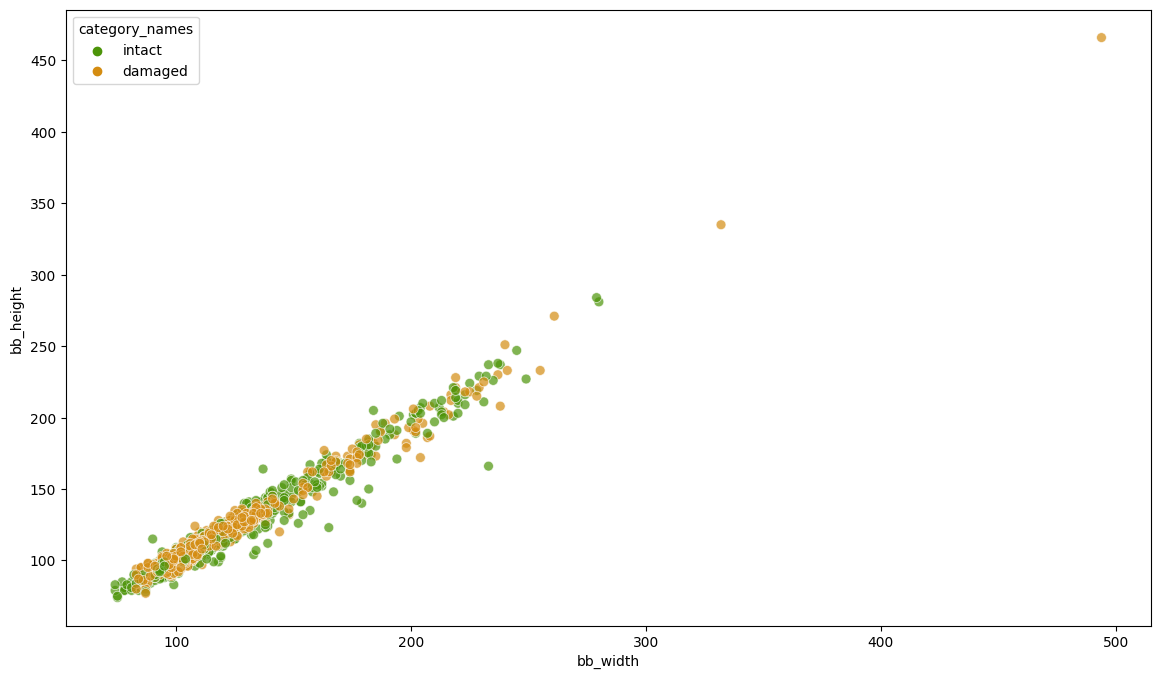

In [12]:
plt.figure(figsize=[14,8])
sns.scatterplot(x='bb_width', y='bb_height', data=df.loc[df['dataset'] == 'train'].reset_index(), hue='category_names', alpha=0.7, s=50, palette=dict(intact="#4c9409", damaged="#d48c11"))

In [13]:
def count_classes(dat, dataset):
    """
    dat: input DataFrame
    dataset: "train", "val", or "test"
    """
    return(df.loc[df['dataset'] == dataset, "category_names"].value_counts())

In [14]:
count_classes(df, "train")

intact     727
damaged    622
Name: category_names, dtype: int64

In [15]:
count_classes(df, "val")

damaged    261
intact     219
Name: category_names, dtype: int64

In [16]:
prepare_annotations().make_dirstructure()

new directory tree prepared


In [17]:
prepare_annotations().make_labels()

length data: 1859
Emptying labelfiles


In [18]:
prepare_annotations().fixed_train_val_split()

Splitting train and validation data
Removed previous files
No previous files train.txt, val.txt or test.txt were found


In [21]:
!cat /dest/train.yaml

cat: /dest/train.yaml: No such file or directory


In [22]:
!cat '/dest/labels/p1.txt'

cat: /dest/labels/p1.txt: No such file or directory


# Further Adjustment for YOLO-NAS
## Handling Images

In [26]:
import glob

count = 0
train_images_files = list()
val_images_files = list()
test_images_files = list()

images_files = list()

for i in glob.glob("raw_data/*"):
    images_files.append(i)

0


In [33]:
train_images_files = images_files[:134]
val_images_files = images_files[134:151]
test_images_files = images_files[151:]

In [44]:
def copy_images_files_labels(mylist, destination):
    for i in mylist:
        shutil.copy(i, destination)
    print("--Copy Done--")

In [42]:
copy_images_files_labels(train_images_files, "dataset/images/train/")
copy_images_files_labels(val_images_files, "dataset/images/val/")
copy_images_files_labels(test_images_files, "dataset/images/test/")

--Copy Done--
--Copy Done--
--Copy Done--


## Handling Labels

In [45]:
import glob

count = 0
train_images_labels = list()
val_images_labels = list()
test_images_labels = list()

images_labels = list()

for i in glob.glob("dest/labels/*.txt"):
    images_labels.append(i)


train_images_labels = images_labels[:134]
val_images_labels = images_labels[134:151]
test_images_labels = images_labels[151:]

copy_images_files_labels(train_images_labels, "dataset/labels/train/")
copy_images_files_labels(val_images_labels, "dataset/labels/val/")
copy_images_files_labels(test_images_labels, "dataset/labels/test/")

--Copy Done--
--Copy Done--
--Copy Done--
